In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import CSVLogger


In [64]:
model = tf.keras.models.load_model('COMPUTER-VISION/pneumonia_model.keras')
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 35, 35, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,102,533 (217.83 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,068,356 (145.22 MB)

In [65]:
# The target layer for Grad-CAM
target_layer = "conv2d_35"
test_img_path = "data/chest_xray/test/PNEUMONIA/person14_virus_44.jpeg"

In [66]:
def get_img_array(img_path, size=(150, 150)):
    # Load image and resize
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # Convert to array
    array = tf.keras.utils.img_to_array(img)
    # Normalize (0 to 1)
    array = array.astype('float32') / 255.0
    # Add batch dimension (1, 150, 150, 3)
    array = np.expand_dims(array, axis=0)
    return array

img_array = get_img_array(test_img_path)

In [75]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Update this to your specific middle layer
TARGET_LAYER_NAME = 'conv2d_35' 

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    base_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    reached_target = False
    for layer in model.layers:
        if reached_target: x = layer(x)
        if layer.name == last_conv_layer_name: reached_target = True
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = base_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_class_channel = preds[:, 0]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # IMPROVEMENT: Use only positive gradients (ReLU)
    # This prevents 'negative' features from clouding the heatmap
    pooled_grads = tf.reduce_mean(tf.nn.relu(grads), axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # IMPROVEMENT: Thresholding
    # This removes the 'blue/green' noise from the background
    heatmap = tf.maximum(heatmap, 0) 
    max_val = tf.math.reduce_max(heatmap)
    if max_val != 0:
        heatmap = heatmap / max_val

    return heatmap.numpy()

def apply_heatmap_to_image(img_path, heatmap, alpha=0.4):
    # Load original
    img = cv2.imread(img_path)
    if img is None: return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Process Heatmap
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]
    jet_heatmap = np.uint8(255 * jet_heatmap)

    # Combine
    superimposed_img = jet_heatmap * alpha + img
    return np.clip(superimposed_img, 0, 255).astype(np.uint8)

In [68]:
print([layer.name for layer in model.layers])

['conv2d_33', 'max_pooling2d_33', 'conv2d_34', 'max_pooling2d_34', 'conv2d_35', 'max_pooling2d_35', 'flatten_11', 'dropout_11', 'dense_22', 'dense_23']


In [76]:
# Try the very last layer for the most 'meaningful' focus
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_35')

# Increase alpha slightly to see the lungs underneath more clearly
final_result = apply_heatmap_to_image(test_img_path, heatmap, alpha=0.5)

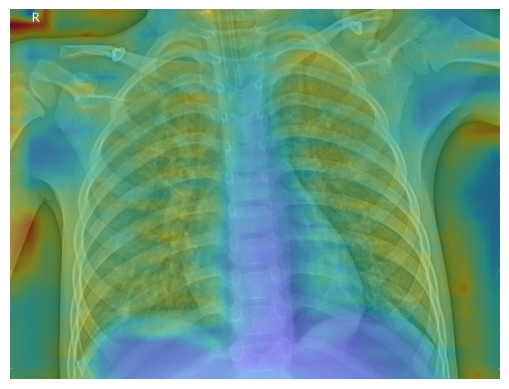

In [77]:
# 1. Define the layer name explicitly
target_layer = 'conv2d_35'

# 2. Pass it into the function
heatmap = make_gradcam_heatmap(img_array, model, target_layer)

# 3. Combine and show
final_result = apply_heatmap_to_image(test_img_path, heatmap)

if final_result is not None:
    plt.imshow(final_result)
    plt.axis('off')
    plt.show()

| **NORMAL (Clear Lungs)** | **PNEUMONIA (Infection Detected)** |
| :---: | :---: |
| <img src="assets/NORMAL_Heatmap.png" width="350"> | <img src="assets/PNEUMONIA_Heatmap.png" width="350"> |
| *Heatmap shows diffuse/clear patterns* | *Heatmap highlights lung opacities* |


**Pneumonia**: Intense "hot" spots (red/yellow) over lung lobes. The model detected opacities or consolidations (fluid/pus) in the lungs.  
**Normal**: Weak, dispersed, or non-existent activation. The lungs are clear and well-aerated; the model found no suspicious density.  
**False Positive**: Hot spots on ribs, heart borders, or medical tubes.	The model is "distracted" by artifacts or high-contrast non-lung areas.

In [ ]:
import matplotlib.pyplot as plt

history_df = pd.read_csv('training_log.csv')

# Plot Accuracy
plt.plot(history_df['accuracy'], label='Train')
plt.plot(history_df['val_accuracy'], label='Val')
plt.title('Accuracy from CSV')
plt.legend()
plt.show()

NameError: name 'pd' is not defined